# Flowsheet Optimization

In [1]:
import pyomo.environ as pyo
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def flow_from_csv(file_path = "FlowData.csv"):
    df = pd.read_csv(file_path, index_col=0)

    data = {}

    for (_, (u, v, flow, cost, penalty)) in df.iterrows():
        data[(u, v)] = {"flow": flow ,"cost" : cost, "penalty" : penalty}

    return data

# Function to define node positions
NODE_POSITIONS = {
    "n0": (-3, 3), "n1": (-3, 2), "n2": (-2, 2.5), "n3": (-1, 2.5),
    "n4": (0, 3.3), "n5": (0, 1.8), "n6": (1, 2.5), "n7": (2, 2.5),
    "n8": (2, 3.3), "n9": (3, 2.5), "n10": (4, 3.3), "n11": (4, 2.8),
    "n12": (4, 2.3), "n13": (4, 1.8), "n14": (5, 2.5), "n15": (6, 2.5),
    "n16": (-3, 0.5), "n17": (-3, -0.5), "n18": (-2, 0), "n19": (-1, 0),
    "n20": (0, 0.8), "n21": (0, 0.3), "n22": (0, -0.2), "n23": (0, -0.8),
    "n24": (1, 0), "n25": (6, 0), "n26": (7, 0), "n27": (8, 0.8),
    "n28": (8, -0.8), "n29": (9, 0), "n30": (10, 0)
}

def get_step_titles():
    return {
        "Step A": (0, 1.4), "Step B": (4, 1.4), "Step C": (0, -1.3), "Step D": (8, -1.3)
    }

# Function to define edges with costs and penalties
EDGES_WITH_WEIGHTS = flow_from_csv()

NODE_COLORS = {
    "V_A": "lightcoral", "V_B": "lightblue", "V_C": "lightgreen"
}

NODE_LABELS = {
    "n4": "V_A", "n5": "V_A", "n13": "V_A", "n11": "V_A",
    "n10": "V_B", "n12": "V_B", "n20": "V_B", "n21": "V_B",
    "n22": "V_C", "n23": "V_C", "n28": "V_C", "n27": "V_C"
}

In [3]:


class FlowsheetOptimization:
    def __init__(self, edges_with_weights = EDGES_WITH_WEIGHTS, node_positions = NODE_POSITIONS):
        """
        Initializes the optimization flowchart with the given edges and node positions.
        Parameters:
        edges_with_weights (dict): A dictionary where keys are tuples representing edges (u, v) and values are dictionaries containing edge attributes such as 'flow', 'cost', and 'penalty'.
        node_positions (dict): A dictionary where keys are node identifiers and values are their positions.
        Attributes:
        edges_with_weights (dict): Stores the edges with their respective weights.
        node_positions (dict): Stores the positions of the nodes.
        graph (networkx.DiGraph): Directed graph representing the flowsheet.
        source_nodes (list): List of source nodes (nodes with no incoming edges).
        inner_nodes (list): List of inner nodes (nodes with both incoming and outgoing edges).
        sink_nodes (list): List of sink nodes (nodes with no outgoing edges).
        flow_network (dict): Dictionary mapping edges to their flow values.
        flow_cost (dict): Dictionary mapping edges to their cost values.
        disj_penalty (dict): Dictionary mapping edges to their penalty values.
        model (pyomo.environ.ConcreteModel): Pyomo model built for optimization.
        """

        self.edges_with_weights = edges_with_weights
        self.node_positions = node_positions
        self.graph = nx.DiGraph()

        for node in self.node_positions.keys():
            self.graph.add_node(node, position = self.node_positions[node])

        for ((u, v), data) in self.edges_with_weights.items():
            self.graph.add_edge(u, v, **data)

        self.source_nodes = []
        self.inner_nodes = []
        self.sink_nodes = []

        for node in self.graph.nodes():
            if self.graph.in_degree(node) == 0:
                self.source_nodes.append(node)
            elif self.graph.out_degree(node) == 0:
                self.sink_nodes.append(node)
            else:
                self.inner_nodes.append(node)

        # self.flow_network = {edge: edge for edge in self.graph.edges()}
        self.flow_network = {(u, v): data["flow"] for (u, v, data) in self.graph.edges(data=True)}
        self.flow_cost = {(u, v): data["cost"] for (u, v, data) in self.graph.edges(data=True)}
        self.disj_penalty = {(u, v): data["penalty"] for (u, v, data) in self.graph.edges(data=True)}
        
        self.model = self.build_pyomo_model()

    def inflow(self, model, node):
        return sum(model.f[edge] for edge in self.graph.in_edges(node))
    
    def outflow(self, model, node):
        return sum(model.f[edge] for edge in self.graph.out_edges(node))

    def build_pyomo_model(self):
        """
        Build a Pyomo optimization model for flowsheet optimization.

        This method constructs a Pyomo ConcreteModel to optimize the flow through a network.
        The model includes binary decision variables for each flow, flow costs, and disjunction penalties.
        It also enforces flow conservation constraints at inner nodes, sink nodes, and source nodes.
        The objective is to minimize the total cost, which includes flow costs and disjunction penalties.

        Returns:
            ConcreteModel: A Pyomo ConcreteModel representing the flowsheet optimization problem.
        """

        model = pyo.ConcreteModel(doc="flowsheet Optimization Model")
        model.flows = pyo.Set(initialize=self.flow_network.keys(), doc="flows")
        model.f = pyo.Var(model.flows, domain=pyo.Binary, doc="flow binary decision on each edge")
        # model.f.display()    
        model.fcost = pyo.Param(model.flows, initialize=self.flow_cost, mutable=True, doc="flow cost")
        model.K = pyo.Param(model.flows, initialize=self.disj_penalty, mutable=True, doc="disjunction penalty")
        total_flow = 1  # Define total_flow as 1 or any other appropriate value

        # Add constraints to ensure flow conservation at each node
        model.inner_flow_conservation = pyo.Constraint(
            self.inner_nodes,
            rule=lambda model, node: self.inflow(model, node) == self.outflow(model, node)
        )

        # Sink nodes should inflow the same amount of flow as the total flow
        model.sink_flow_conservation = pyo.Constraint(
            rule=lambda model: (sum(self.inflow(model, node) for node in self.sink_nodes) == total_flow)
        )

        # Source nodes should outflow the same amount of flow as the total flow
        model.source_flow_conservation = pyo.Constraint(
            rule=lambda model: (sum(self.outflow(model, node) for node in self.source_nodes) == total_flow)
        )

        # NOTE: If control of inflow / outflow of the whole process is desired, extra data must be
        # included and `self.inflow` and `self.outflow` in rules above must be swaped.

        model.totalcost = pyo.Objective(
            expr = sum(model.f[edge] * model.fcost[edge] for edge in self.graph.edges()) * total_flow
                 + sum(model.f[edge] * model.K[edge] for edge in self.graph.edges()),
            sense=pyo.minimize,
            doc="total cost",
        )

        return model

    def solve_model(self):
        solver = pyo.SolverFactory("gurobi")
        solver.solve(self.model, tee=True)
        return {edge: pyo.value(self.model.f[edge]) for edge in self.graph.edges()}
    

In [4]:


def visualize_optimized_network(edges_with_weights, optimized_flows):

    """
    Visualizes the optimized network using NetworkX and Matplotlib.
    Parameters:
        edges_with_weights (dict): A dictionary where keys are tuples representing edges (u, v) and values are dictionaries containing edge attributes such as 'flow', 'cost', and 'penalty'.
        optimized_flows (dict): A dictionary where keys are tuples representing edges (u, v) and values are the optimized flow values.
    Returns:
        None
    """

    G = nx.DiGraph()
    G.add_edges_from(edges_with_weights.keys())
    pos = NODE_POSITIONS
    plt.figure(figsize=(30, 14))

    # Assign node colors and labels
    node_color_list = [NODE_COLORS.get(NODE_LABELS.get(node, ""), "lightgray") for node in G.nodes()]
    labels = {node: NODE_LABELS.get(node, node) for node in G.nodes()}

    nx.draw(G, pos, with_labels=True, labels=labels, node_size=1500, node_color=node_color_list, edgecolors='black', font_size=14)
    
    active_edges = [edge for edge, decision in optimized_flows.items() if decision == 1]
    inactive_edges = [edge for edge, decision in optimized_flows.items() if decision == 0]

    nx.draw_networkx_edges(G, pos, edgelist=inactive_edges, arrowstyle="-", edge_color='black', width=3)
    nx.draw_networkx_edges(G, pos, edgelist=active_edges, arrowstyle="-", edge_color='blue', width=3)

    edge_labels = {
        edge: f"F{i+1}: {optimized_flows[edge]}\nCost: {data['cost']}\nPenalty: {data['penalty']}"
        for i, (edge, data) in enumerate(edges_with_weights.items())
    }
    
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels=edge_labels, font_color='black', font_size=10, label_pos=0.5,
        bbox=dict(facecolor='white', edgecolor='none', alpha=1)
    )

    step_titles = get_step_titles()
    for title, position in step_titles.items():
        plt.text(position[0], position[1], title, fontsize=24, fontweight="bold", color="orange", ha="center", va="center")
    
    plt.title("Optimized Flowsheet", fontsize=36, fontweight="bold", loc="left")
    plt.show()


flowsheet Optimization Model

    1 Set Declarations
        flows : flows
            Size=1, Index=None, Ordered=Insertion
            Key  : Dimen : Domain : Size : Members
            None :     2 :    Any :   38 : {('n0', 'n2'), ('n1', 'n2'), ('n2', 'n3'), ('n3', 'n4'), ('n3', 'n5'), ('n4', 'n6'), ('n5', 'n6'), ('n6', 'n7'), ('n7', 'n9'), ('n8', 'n7'), ('n9', 'n10'), ('n9', 'n11'), ('n9', 'n12'), ('n9', 'n13'), ('n10', 'n14'), ('n11', 'n14'), ('n12', 'n14'), ('n13', 'n14'), ('n14', 'n15'), ('n15', 'n25'), ('n16', 'n18'), ('n17', 'n18'), ('n18', 'n19'), ('n19', 'n20'), ('n19', 'n21'), ('n19', 'n22'), ('n19', 'n23'), ('n20', 'n24'), ('n21', 'n24'), ('n22', 'n24'), ('n23', 'n24'), ('n24', 'n25'), ('n25', 'n26'), ('n26', 'n27'), ('n26', 'n28'), ('n27', 'n29'), ('n28', 'n29'), ('n29', 'n30')}

    2 Param Declarations
        K : disjunction penalty
            Size=38, Index=flows, Domain=Any, Default=None, Mutable=True
            Key            : Value
              ('n0', 'n2') :  

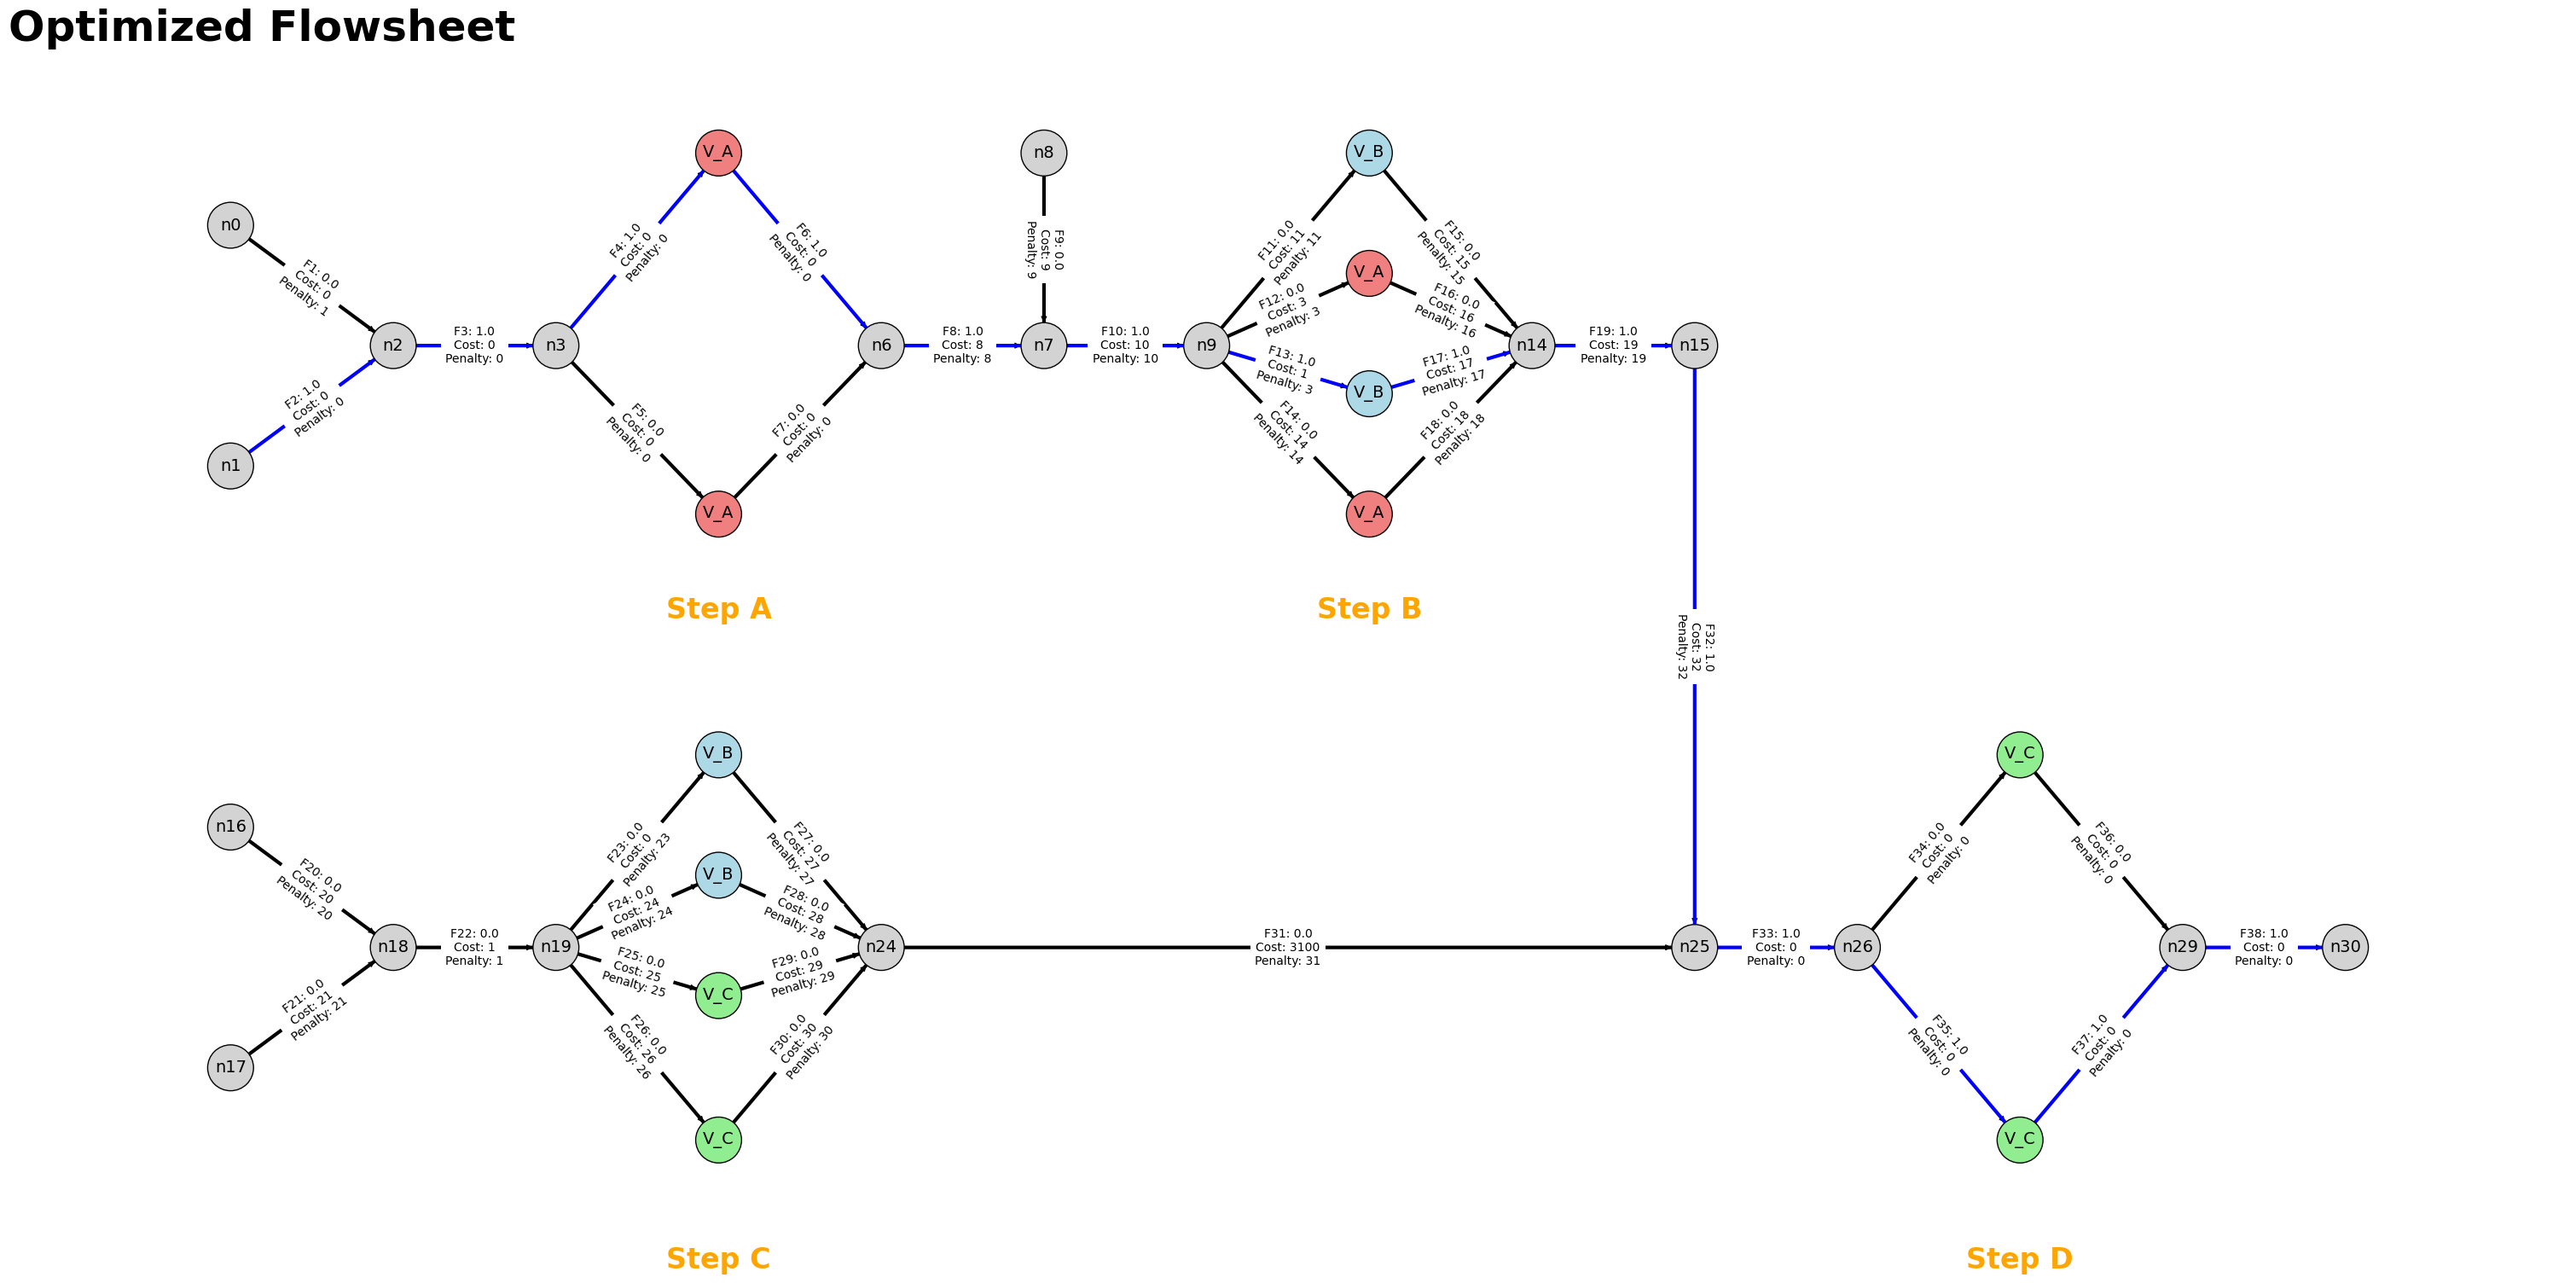

In [5]:

def main():
    """
    Main function to execute the flowsheet optimization process.

    This function performs the following steps:
    1. Initializes the FlowsheetOptimization object.
    2. Prints the model details.
    3. Solves the optimization model to get the optimized flows.
    4. Visualizes the optimized network using the edges with weights and the optimized flows.

    Returns:
        None
    """

    optimizer = FlowsheetOptimization()
    optimizer.model.pprint()
    optimized_flows = optimizer.solve_model()
    visualize_optimized_network(optimizer.edges_with_weights, optimized_flows)

if __name__ == "__main__":
    main()